# Group Balance Project

## Report Outline
* [Introduction](#introduction)
* [Theoretical background](#theoretical_background)
* [Time dependency](#Time_dependency)
* [Multicollinearity](#multicollinearity)
* [Train-test split](#train-test)
* [Elastic net](#elastic_net)
* [Multi sample splitting](#multi_sample_splitting)
* [Conclusion](#conclusion)


## <a class="anchor" id = "introduction"></a> Introduction

The dataset used in this project is comprised of the kinematic parameters (joint angular positions, velocities and accelerations) of the KUKA LWR robot ([original repo](https://github.com/fmeier/kuka-data) associated with the dataset). This time-series dataset was chosen based on the research interests of one of the group members, and we decided that it would be interesting to apply the methods taught in Part 2: Shrinkage and regularization of the course to it. </br> </br>

Thus we chose to analyse data based on methods with regularization and shrinkage. 
We want our end goal to be inference, so we choose to use Lasso as our method of regularization. 
As we will later observe our data is correlated and we need to use elastic-net to not have convergence issues. 
For better interpretability we have chosen to use multi-sample splitting. 
Finally we compare MSE for the test set for the final model and compare to OLS with all covariates and elastic net. This is done to assess if predictive power is lost for the sake of interpretability.   </br> </br>

This dataset does not have missing values, as it is most likely curated and gathered from a lab with high quality equipment. 
So we will not handle missing values for this report. 
</br> </br>

We want to note that this is effectively a time series dataset, which should be handled by taking that into account. 
In this case we did some pre-processing to try to mitigate this effect, but it is still present after the manipulation. 
As a consequence the results of this project should not be blindly accepted, and more thorough research should be done before any conclusions can be drawn. 
With that said the pipeline to do regression and multi-sample splitting is still valid. 
</br> </br>

The Python libraries we have used in this project are as follows: 

In [51]:
import pandas as pd # for dataframes
import numpy as np # general quality of life
import random # choose random response
from sklearn.preprocessing import StandardScaler # scale covariates
from sklearn import linear_model, metrics # Elastic net and find MSE
from sklearn.model_selection import train_test_split # train-test split

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf # pacf for time dependency check
from statsmodels.regression.linear_model import OLS # OLS with variance of effects
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt # plotting
import seaborn as sns; sns.set(style='white') # correlation plots
from IPython.display import Image # import of local images

In [31]:
joint_states = []
joint_taus = []
for i in range(1, 8):
    joint_states.append("j%s_pos" % str(i))
    joint_states.append("j%s_vel" % str(i))
    joint_states.append("j%s_acc" % str(i))
    joint_taus.append("tau%s" % str(i))
col_names = joint_states + joint_taus

In [32]:
df = pd.read_table("kuka1_offline.txt", delimiter=' ', header=None, names=col_names)
#df.columns=col_names

An excerpt of the dataset, which consists of joint positions, velocities, angles and torques (taus) is shown below:

In [33]:
df.head()

j1_pos  j1_vel   j1_acc    j2_pos  j2_vel    j2_acc   j3_pos    j3_vel  \
0  1.0757 -1.2595 -0.35325 -0.089857 -1.5600 -0.000607  0.89713 -0.052099   
1  1.0714 -1.2624 -0.36145 -0.093417 -1.5651 -0.007596  0.89576 -0.055493   
2  1.0668 -1.2652 -0.36960 -0.097245 -1.5702 -0.014550  0.89433 -0.057842   
3  1.0622 -1.2680 -0.37772 -0.101160 -1.5753 -0.021527  0.89289 -0.057124   
4  1.0577 -1.2710 -0.38586 -0.104840 -1.5804 -0.028612  0.89136 -0.055340   

     j3_acc   j4_pos  ...    j7_pos    j7_vel    j7_acc      tau1      tau2  \
0 -0.035979 -0.10278  ...  0.010593  0.004751 -0.008959 -0.026228 -0.022875   
1 -0.035536 -0.10217  ...  0.014996  0.010237 -0.014428 -0.016953 -0.022724   
2 -0.035284 -0.10151  ...  0.003699 -0.004047 -0.001188 -0.010498 -0.028455   
3 -0.035983 -0.10163  ... -0.007597 -0.030177 -0.021932 -0.011402 -0.030138   
4 -0.037200 -0.10196  ... -0.002730 -0.022796 -0.045287 -0.020397 -0.015827   

       tau3     tau4     tau5     tau6     tau7  
0 -0.060884 -0.13152 -0.27893 -0.26200 -0.28018  
1 -0.060496 -0.12743 -0.27729 -0.26489 -0.28682  
2 -0.061434 -0.12192 -0.27786 -0.26719 -0.29418  
3 -0.060592 -0.12091 -0.27432 -0.26839 -0.30826  
4 -0.059432 -0.12411 -0.27263 -0.26680 -0.31185  

[5 rows x 28 columns]

In [34]:
# Number of rows for the original dataset
len(df)

17560

# <a class="anchor" id = "theoretical_background"></a> Theoretical background

The dynamical model of a robot manipulator is complex, nonlinear, and not straightforward to estimate. For the 7 (robotic) degrees of freedom (DoF) KUKA-LWR robot arm (see [
link](https://github.com/fmeier/kuka-data) for details), it may be formulated in classical "mass-spring-damper" form as follows:

$\tau = M(\theta)\ddot{\theta} + B(\theta)[\dot{\theta_{i}}\dot{\theta_{j}}] + C(\theta)[\dot{\theta}^2] + G(\theta)$ </br>

where $\tau$ is a $7 \times 1$ vector of manipulator joint torques, </br>
$\theta_i:$ ji_pos, or joint angle<br>
$\dot{\theta}_i:$ ji_vel, or joint angular velocity<br>
$\ddot{\theta}_i:$ ji_acc, or joint angular acceleration<br>
$i = 1, ..., 7$ for the 7 joints (DoFs)</br>

$M$ is the $7 \times 7$ mass matrix of the manipulator </br>
$B$ and $C$ are the matrices of Coriolis and centrifugal terms, respectively, and </br>
$G$ is the vector of restoring terms </br>

The $M$, $B$ and $C$ matrices contain sums and/or products of sinusoidal terms of the "original", kinematic covariates ${\theta, \dot{\theta}, \ddot{\theta}}$, which could be of the form of e.g. $asin(\phi_{i})cos(\phi_{i})$, where ${\phi \in \{\theta, \dot{\theta}, \ddot{\theta}\}}$ and $i \in \{1,...,7\}$. The $B$ matrix is multiplied with "cross-$\theta$" terms $\dot{\theta_{i}}\dot{\theta_{j}}$. We treat the sinusoidal terms as a power series of $\phi$s, making use of the following mathematical identities:

$$
    \sin(x) = x - \frac{x^3}{3!} + \frac{x^5}{5!} - \dots \\
    \cos(x) = 1 - \frac{x^2}{2!} + \frac{x^4}{4!} - \dots
$$

In order to keep the number of covariates to a reasonable number or have a less complex model, we do not consider the fully-linearized model - i.e. we model the covariates as a polynomial of up to degree 2, i.e., we use both the observed kinematic dataset values in the dataset, as well as their squared-values - in mathematical terms - $\theta, \dot{\theta}, \ddot{\theta}, \theta^2, \dot{\theta}^2, \ddot{\theta}^2$, and ignore the "cross-$\theta$" terms $\dot{\theta_{i}}\dot{\theta_{j}}$ and higher order polynomial terms, as the magnitudes/absolute values in our dataset are not particularly high (may be inspected my uncommenting the lines of code in the cell below).

In [35]:
###### Eyeball check for: #####

# df.max() # max positive values
# df.min() # min negative values
# max(df.abs().max()) # max absolute value

An illustration of the KUKA robot arm (courtesy of [Mueller et al.](https://www.researchgate.net/publication/318726610_Towards_a_Unified_Notion_of_Kinematic_Singularities_for_Robot_Arms_and_Non-holonomic_Platforms) ) is as follows:
<!-- <img src='Kinematic-model-of-a-7-DOF-KUKA-LWR.png'  height=”2”> -->
<!-- <img src="./Kinematic-model-of-a-7-DOF-KUKA-LWR.png" style="height: 300px;"/> -->

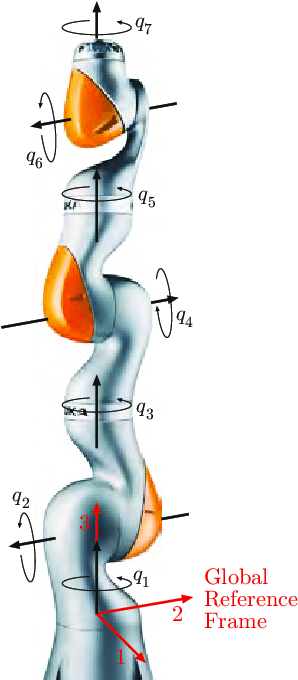

In [36]:
Image(filename = "Kinematic-model-of-a-7-DOF-KUKA-LWR.png", width = 100, height = 300)

### <a class = "anchor" id = "time_dependency"></a> Time dependency
Due to the mechanical nature of the dataset we have a time dependency in our data. 
We can see in the following plots that this is the case. 
One major problem of this is the possibility of the residuals being time dependent, we check for this with both the ACF (autocorrelation function) and the PACF (partial autocorrelation function) and can observe that this is the case ref. [book](https://link.springer.com/book/10.1007/978-3-662-63882-8).

One of the assumptions for OLS is that the errors are independent, and in our case since our model does not capture the time dependency this is not the case. 

What one should do is to do time analysis to capture this moving average and then try to model the underlying effects. 

But since our main focus is regularization and shrinkage, we choose an arbitrary sampling period of $t = 100$ to mitigate the effects of time-dependent residuals. This sampling step will remove approximately 99% of the observations. Then, we pray that the autocorrelation is small enough to not influence our analysis. 



Our original dataset has 17560 observations, but after our removal we have 176 observations. 

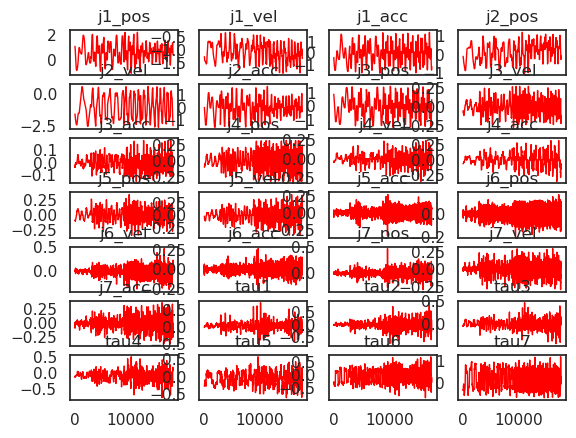

In [37]:
# Plots
fig, axes = plt.subplots(nrows=7, ncols=4)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color="red", linewidth=1)
    ax.set_title(df.columns[i])
plt.show()

We can also observe from the above figure that all covariates are part of a continuous motion, which makes likely that the respose we choose is also dependent on this motion. 
In other words dependent on previous covariates which results in a time dependency we cannot capture without alterations to the standard workflow. 
Our solution is quite low effort and ultimately only reduces the time-dependency instead of completely removing it. 

RANDOM ELEMENT:  0


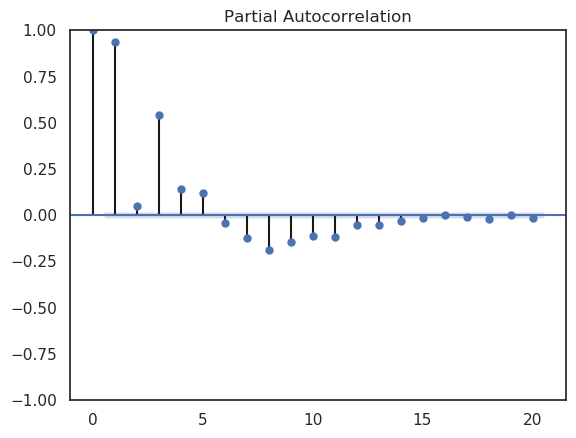

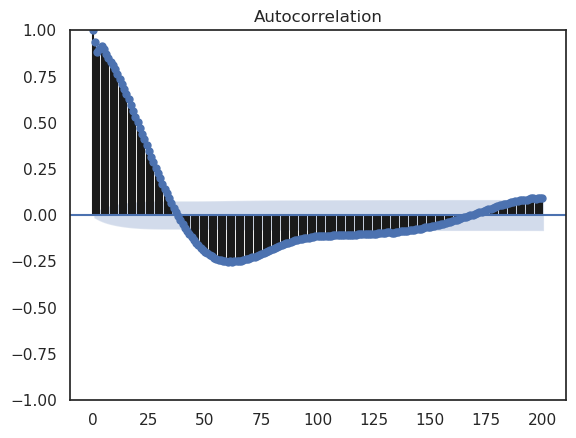

In [38]:
random.seed(123)
# Data manipulation
# separate covariates from the response
base_covariates = df.iloc[:, 0:21] 
# find response and center it
rand_elem = random.randint(0, 6)
print("RANDOM ELEMENT: ", rand_elem)
response = df.iloc[:, 21 + rand_elem].rename("response")

# standardize variables, we use both squared and original values for covariates
covariates = pd.concat([base_covariates, 
                        np.square(base_covariates).add_suffix('_2')], 
                        axis = 1)

# reorganize to data frame
covariates = pd.DataFrame(covariates, columns = covariates.columns)

# check residuals for LS for time dependency
reg = linear_model.LinearRegression().fit(covariates, response)
resid = response - reg.predict(covariates)

plot_pacf(resid, lags = 20, method = "ywm")
plt.show()
plot_acf(resid, lags = 200)
plt.show()

In a non time dependent dataset both the ACF and PACF would have 1 correlation for 0 lag and 0 correlation for all others. 
These functions are often used to figure out which type of model should be used to fit the time series dataset to. 
In the figure above we observe that both the PACF and ACF goes towards zero, where both goes into the negative spectrum before it tails off. 
There is some weird behaviour of the ACF we will not go into detail of. 

In [39]:
# Sample data at intervals of 100 (arbitrary-chosen interval) -> reduce dataset from N = 17560 to N = 176
sample_interval = 100
downsampled_df = df.iloc[::sample_interval, :]
downsampled_df.reset_index(inplace=True, drop = True)

In [40]:
linear_covariates = downsampled_df.iloc[:, 0:21]

response = downsampled_df.iloc[:, 21 + rand_elem].rename("response") 
covariates_ds = pd.concat([linear_covariates, 
                        np.square(linear_covariates).add_suffix('_2')],
                        axis = 1)
covariates_ds = pd.DataFrame(covariates_ds, columns = covariates_ds.columns)

In [41]:
covariates_and_response = pd.concat([covariates_ds, response],
                        axis = 1)

For the sake of a sanity check we plot the q-q plot for the residuals from OLS from both the entire
dataset and the sampled dataset. This is based on the training set, or in other words the data used
to fit the model. In the plots below we can observe that with the chosen covariates, from Section 2
the sampled dataset has a better fit than the entire dataset. Here the non-sampled one is the one
above, and the sampled one the one below.

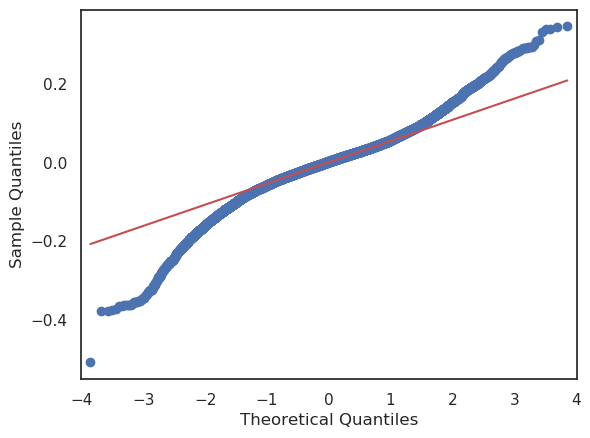

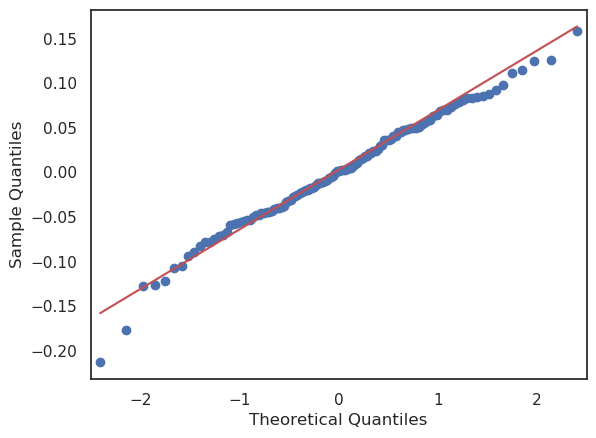

In [52]:
resid_sample = train_response - only_lm.predict(train_covariates)
qqplot(resid, line = "q")
plt.show()
qqplot(resid_sample, line = "q")
plt.show()

### <a class = "anchor" id = "multicollinearity"></a> Multicollinearity
We can observe some high correlations between our covariates, which can be observed in the Figure below. 
This has the potential to give Lasso convergence issues. 
So we choose to go with elastic net instead of lasso, as the ridge term is better at dealing with correlated effects. 
Further our main goal is to find the most significant effects for inference, so we still want to keep the Lasso term. 

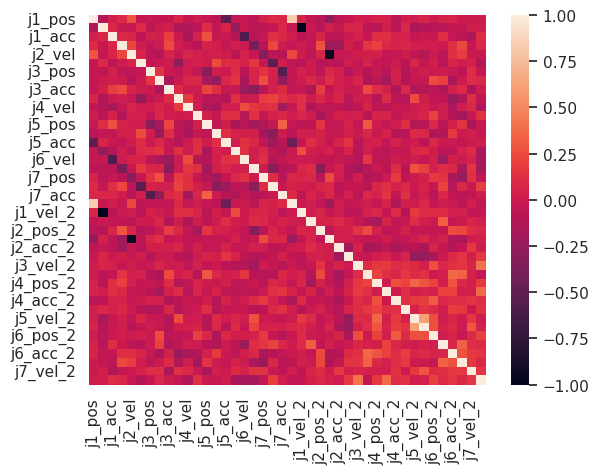

In [42]:
corrMatrix = covariates_ds.corr()
sns.heatmap(corrMatrix, vmin = -1, vmax = 1)
plt.show()

## <a class = "anchor" id = "train-test"></a> Train-test split
As we want to do some prediction we want to split our data into a training and test set. 
For this we choose a split where $30\%$ of our data is reserved for the test set. 
Due to the scope of the project, we assume that there is no sign of the time dependency left in the data at this point.

In [43]:
# Split data into test and train sets random, e.g. 70/30  (random shuffle)
random.seed(123)
train, test = train_test_split(covariates_and_response, test_size=0.3)

### <a class = "anchor" id = "elastic_net"></a> Elastic net

Hyperparameters are chosen based on cross-validation, except for the $\alpha$ in the minimization problem;
$$
    \text{minimize}_{\beta} \left\{ \sum_{i = 1}^N \left(y_i - \sum_{j = 1}^p x_{i j} \beta_j \right)^2 + \lambda \left( \sum_{j = 1}^p \frac{1}{2} (1 - \alpha) \beta_j^2 + \alpha |\beta| \right) \right\}.
$$
In our case $\alpha$ was chosen based on how large it could be whilst not giving convergence issues. 

For regularization/shrinkage techniques we want to standardize our covariates, to penalize all covariates equally. 
If not done this could become a problem if some of the covariates are of different scales. 
Further we want to center our response so we do not have to estimate an intercept. 
We standardize the train data based on its own values, then used the estimated mean and standard deviation of the training data to standardize the test data. 
For our responses we only center them based on the mean of the train responses to remove the necessity for an intercept. 

In [44]:
# standardize based on training data to not bleed information from test set into training set
scaler = StandardScaler()
train_covariates = pd.DataFrame(scaler.fit_transform(train.iloc[:,:-1]), columns = covariates.columns)
train_response = train.iloc[:, 42]
train_response = train_response.subtract(train_response.mean()).reset_index(drop = True)

# Note that we use the transformation fitted on the train data on the test set
test_covariates = pd.DataFrame(scaler.transform(test.iloc[:,:-1]), columns = covariates.columns)
test_response = test.iloc[:, 42]
test_response = test_response.subtract(train_response.mean()).reset_index(drop = True)

### <a class = "anchor" id = "multi_sample_splitting"></a> Multi Sample splitting
The motivation for sample splitting is to find valid p-values and confidence intervals whilst using Lasso/elastic net.
This is done by splitting the training data in two, where the first part is used to fit a lasso/elastic net model. 
Then the second set is used to fit an OLS model with only the effects that were estimated to be non-zero in the lasso/elastic net model. 
Note that the effects that were estimated to zero will get a p-value of $1$. 
From this OLS we can find p-values, which we adjust by multiplying by the number of non-zero estimated effects. 
This can be shown to follow the Bonferroni method, which controls the family wise error rate. 

For multi-sample splitting we would like to do this many times. 
Normally the sample split is used as explained, and then the first and second part are interchanged and used as a second split. 
So for each split we make we can find two valid p-values. 
After making a given number of estimates we find the p-values for each effect by multiplying the median of the p-value for an effect with two. 
There are other valid ways to find p-values from the vector of p-values, but this is the one we have chosen. 

In [45]:
# Note that due to the high correlation between some of the covariates we need to use elastic net instead of just Lasso. 
# We also need to use l1_ratio <= 0.5, 0.3 is arbitrary but works in random sample
def multi_split_lasso(covariates, response, I = 2000):
    # number of observations
    N = len(covariates)

    # create matrix for holding P values
    # Initialize with 1, such that we only need to alter the p-values for covariates included in the model
    P = pd.DataFrame([[1.0 for _ in range(len(covariates.iloc[0]))] for _ in range((I//2)*2)])

    for i in range(0, I//2):
        # choose half of the dataset without replacement
        first_set = random.sample(range(0, N), N//2)

        # find the indexes of the other half based on set interactions
        second_set = list(
            set(range(0, N)).difference(set(first_set))
            )
        
        # first model, based on first set
        first_lasso = linear_model.ElasticNetCV(cv = 10, fit_intercept = False, 
                                                l1_ratio=0.5, max_iter = 4000) # find lambda through CV
        first_lasso.fit(covariates.iloc[first_set], response.iloc[first_set])

        # second model, based on second_set
        second_lasso = linear_model.ElasticNetCV(cv = 10, fit_intercept = False, 
                                                 l1_ratio=0.5, max_iter = 4000) # find lambda through CV
        second_lasso.fit(covariates.iloc[first_set], response.iloc[first_set])

        # first linear model based on first_lasso and second_set
        # endog - 1-d endogenous response variable (nobs in length)
        # exog  - nobs x k array of observations, k is number of regressors
        lm_1 = OLS(endog = response.iloc[second_set], 
                      exog = covariates.iloc[second_set, 
                                             np.where(first_lasso.coef_ != 0)[0]
                                             ]).fit()
        # adjust p-values (Bonferroni method controlling FWER) 
        P.iloc[2*i, np.where(first_lasso.coef_ != 0)] = lm_1.pvalues*len(lm_1.pvalues)

        # second linear model based on second_lasso and first_set
        lm_2 = OLS(endog = response.iloc[first_set], 
                      exog = covariates.iloc[first_set, 
                                             np.where(second_lasso.coef_ != 0)[0]
                                             ]).fit()
        # adjust p-values (Bonferroni method controlling FWER) 
        P.iloc[2*i + 1, np.where(second_lasso.coef_ != 0)] = lm_2.pvalues*len(lm_2.pvalues)
    # One way to get valid p-values is to find the median and multiply with 2
    # P_vector = 2 * multi_split_P.median(axis = 0)
    P_vector = 2 * P.median(axis = 0)
    # replace all p-values larger than 1 with 1
    P_vector[P_vector > 1] = 1

    return P_vector

# example of functionable code
random.seed(123)
multi_split_P = multi_split_lasso(train_covariates, train_response)

In [46]:
# First find significant covariates and create OLS based on that
# Then find OLS based on all covariates and compare the MSE
criteria = multi_split_P < 0.05
train_covariates.iloc[:, criteria.index[criteria]]

# lasso based LM (from p-values from multi sample splitting)
lasso_lm = linear_model.LinearRegression(fit_intercept=False).fit(X = train_covariates.iloc[:, criteria.index[criteria]], 
                                                                  y = train_response)
lasso_lm_pred = lasso_lm.predict(X = test_covariates.iloc[:, criteria.index[criteria]])
lasso_lm_MSE = metrics.mean_squared_error(y_true = test_response, y_pred = lasso_lm_pred)

only_lm = linear_model.LinearRegression(fit_intercept=False).fit(X = train_covariates, 
                                                                  y = train_response)
only_lm_pred = only_lm.predict(X = test_covariates)
only_lm_MSE = metrics.mean_squared_error(y_true = test_response, y_pred = only_lm_pred)

non_lasso_lm = linear_model.ElasticNetCV(cv = 10, fit_intercept=False, l1_ratio=0.5).fit(X = train_covariates, y = train_response)
non_lasso_pred = non_lasso_lm.predict(X = test_covariates)
non_lasso_MSE = metrics.mean_squared_error(y_true = test_response, y_pred = non_lasso_pred)


# Comparison of the predictive power of multi-sample splitting 

In [47]:
print("Significant effects found from multi-sample splitting:", list(test_covariates.iloc[:, criteria.index[criteria]].columns))
# print("Coefficients for the elastic net:\n", non_lasso_lm.coef_)
print("Non-zero effects from standard elastic net:\n", list(test_covariates.iloc[:, non_lasso_lm.coef_ != 0].columns))
# Print of results
print("MSE for OLS based on multi-sample splitting:", round(lasso_lm_MSE, 5), 
      "\nMSE for OLS for all covariates:", round(only_lm_MSE, 5), 
      "\nMSE for elastic net:", round(non_lasso_MSE, 5))
print(round(100*(1 - lasso_lm_MSE/only_lm_MSE), 2), "% lower MSE for OLS based on multi-sample splitting \n(compared to OLS for all covariates) ")
print(round(100*(1 - non_lasso_MSE/only_lm_MSE), 2), "% lower MSE for elastic net than OLS. ")

Significant effects found from multi-sample splitting: ['j5_acc']
Non-zero effects from standard elastic net:
 ['j1_pos', 'j3_pos', 'j3_vel', 'j3_acc', 'j5_pos', 'j5_acc', 'j6_vel', 'j6_acc', 'j2_pos_2', 'j4_pos_2', 'j5_pos_2', 'j6_pos_2', 'j6_acc_2']
MSE for OLS based on multi-sample splitting: 0.00516 
MSE for OLS for all covariates: 0.00797 
MSE for elastic net: 0.00525
35.22 % lower MSE for OLS based on multi-sample splitting 
(compared to OLS for all covariates) 
34.14 % lower MSE for elastic net than OLS. 


We observe that even though elastic net removes a lot of the effects, a decent number still remain. 
For multi-sample splitting we end up with only one effect, note that the the effect does not make a lot of sense from a physics standpoint. 
But we still end up with similar MSE for the test set for both of these models. 
In the end the multi-sample splitting is more interpretable, and has similar prediction accuracy to elastic net. 

## <a class = "anchor" id = "conclusion"></a> Conclusion

### From a robotics perspective
From multi-sample splitting we find only the acceleration of joint $5$, which is weird as it is used to esitmate $\tau$ for joint $1$. 
We would question why this is the case and considered potential other covariates/interactions i.e. the kinematic values (angular positions, velocities, accelerations) of other joints that could have been relevant. 

This unintuitive physical result may be, in part, due to the oversimplifying assumptions we have made (or underparameterization) w.r.t. the highly nonlinear model with many (robotic) degrees of freedom (DoFs), so we speculate if we would have arrived at a different result, had we modelled the system differently, or used a datasaet for a manipulator with fewer DoFs.

### From a statistical inference perspective

The general observation is that both multi-sample splitting and elastic net does better than OLS when it comes to MSE. 

However, whether elastic net or multi-sample splitting has better performance, depends on the $\tau$ that is chosen, and the reader is welcome to try experimenting with using different responses $\tau$s in the attached IPython notebook.

Nevertheless, multi-sample splitting is a lot more interpretable because it emphasizes the most relevant covariates to the model.